In [1]:
%matplotlib inline

In [15]:
import sys
print(sys.executable)

import os
import glob
import pickle
from collections import namedtuple, defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as plticker

import wandb
api = wandb.Api()


def save_fig(filename, file_format='pdf', tight=True, **kwargs):
    if tight:
        plt.tight_layout()
    filename = "figures/{}.{}".format(filename, file_format)
    filename = filename.replace(' ', '-')
    plt.savefig(filename, format=file_format, dpi=1000, **kwargs)

/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7


In [19]:
def draw_line(log, method, avg_step=3, mean_std=False, max_step=None, max_y=None, x_scale=1.0, ax=None, idx=0,
             smooth_steps=10, num_points=50, linestyle='-', no_fill=False, smoothing_weight=0.):
    steps = {}
    values = {}
    max_step = max_step * x_scale
    seeds = log[method].keys()
    for seed in seeds:
        step = np.array(log[method][seed].steps)
        value = np.array(log[method][seed].values)
        
#         step = step[2:]
#         value = value[2:]
        
        # filter NaNs
        for i in range(len(value)):
            if np.isnan(value[i]):
                if i == 0: 
                    value[i] = 0
                else:
                    value[i] = value[i-1]
        
#         # make binary
#         for i in range(len(value)):
#             value[i] = 1 if value[i] > 0 else 0
        
        if max_step:
            max_step = min(max_step, step[-1])
        else:
            max_step = step[-1]

        steps[seed] = step
        values[seed] = value
    
    # exponential moving average smoothing
    for seed in seeds:
        last = values[seed][0]  # First value in the plot (first timestep)
        smoothed = list()
        for point in values[seed]:
            smoothed_val = last * smoothing_weight + (1 - smoothing_weight) * point  # Calculate smoothed value
            smoothed.append(smoothed_val)                        # Save it
            last = smoothed_val                                  # Anchor the last smoothed value
        values[seed] = smoothed
        
    # cap all sequences to max number of steps
    data = []
    for seed in seeds:
        for i in range(len(steps[seed])):
            if steps[seed][i] <= max_step:
                data.append((steps[seed][i], values[seed][i]))
    data.sort()
    x_data = []
    y_data = []
    for step, value in data:
        x_data.append(step)
        y_data.append(value)
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    min_y = np.min(y_data)
    max_y = np.max(y_data)
    #l = sns.lineplot(x=x_data, y=y_data)
    #return l, min_y, max_y

    # filling
    if not no_fill:
        n = len(x_data)
        avg_step = int(n // num_points)

        x_data = x_data[:n // avg_step * avg_step].reshape(-1, avg_step)
        y_data = y_data[:n // avg_step * avg_step].reshape(-1, avg_step)
        
        std_y = np.std(y_data, axis=1)
        
        avg_x, avg_y = np.mean(x_data, axis=1), np.mean(y_data, axis=1)        
    else:
        avg_x, avg_y = x_data, y_data
        
    # subsampling smoothing
    n = len(avg_x)
    ns = smooth_steps
    avg_x = avg_x[:n // ns * ns].reshape(-1, ns).mean(axis=1)
    avg_y = avg_y[:n // ns * ns].reshape(-1, ns).mean(axis=1)
    if not no_fill:
        std_y = std_y[:n // ns * ns].reshape(-1, ns).mean(axis=1)
        
    if not no_fill:
        ax.fill_between(avg_x, np.clip(avg_y - std_y, 0, max_y), np.clip(avg_y + std_y, 0, max_y), 
                        alpha=0.1, color='C%d' % idx)#, facecolor=facecolor)
        
    l = ax.plot(avg_x, avg_y, label=method)
    plt.setp(l, linewidth=2, color='C%d' % idx, linestyle=linestyle)
    # 4 if 'Ours' not in method else 2


    return l, min_y, max_y


def draw_graph(logs, title, methods, xlabel='Step', ylabel='Success', legend=False, put_title=True,
               mean_std=False, min_step=0, max_step=None, min_y=None, max_y=None, smooth_steps=10, 
               num_points=50, no_fill=False, num_x_tick=5, legend_loc=2, smoothing_weight=0.,
               filename=None):
    max_value = -999
    min_value = 999
    
    fig, ax = plt.subplots(figsize=(5, 4))
    
    lines = []
    num_colors = len(methods)
    for idx, method in enumerate(methods):
        seeds = logs[method].keys()
        if len(seeds) == 0:
            continue
        
        linestyle = '--' if 'final_d' in method else '-'
        l_, min_, max_ = draw_line(logs, method, mean_std=mean_std, max_step=max_step, max_y=max_y, 
                                   x_scale=1.0, ax=ax, idx=num_colors - idx - 1, 
                                   smooth_steps=smooth_steps, num_points=num_points, linestyle=linestyle,
                                   no_fill=no_fill, 
                                   smoothing_weight=smoothing_weight[idx] if isinstance(smoothing_weight, list) \
                                                    else smoothing_weight)
        #lines += l_
        max_value = max(max_value, max_)
        min_value = min(min_value, min_)

    if min_y == None:
        min_y = int(min_value - 1)
    if max_y == None:
        max_y = max_value
        #max_y = int(max_value + 1)
    if max_y == 1:
        plt.yticks(np.arange(min_y, max_y + 0.1, 0.2), fontsize=12)
    else:
        if max_y > 1:
            plt.yticks(np.arange(min_y, max_y, (max_y - min_y) / 5), fontsize=12)  # make this 4 for kitchen
        elif max_y > 0.8:
            plt.yticks(np.arange(0, 1.0, 0.2), fontsize=12)
        elif max_y > 0.5:
            plt.yticks(np.arange(0, 0.8, 0.2), fontsize=12)
        elif max_y > 0.3:
            plt.yticks(np.arange(0, 0.5, 0.1), fontsize=12)
        elif max_y > 0.2:
            plt.yticks(np.arange(0, 0.4, 0.1), fontsize=12)            
        else:
            plt.yticks(np.arange(0, 0.2, 0.05), fontsize=12)            
            
    plt.xticks(np.round(np.arange(min_step, max_step + 0.1, (max_step - min_step) / num_x_tick), 2), fontsize=12)
    ax.grid(b=True, which='major', color='lightgray', linestyle='--')

    ax.set_xlabel(xlabel, fontsize=16) #'large')
    #plt.ylabel(ylabel, fontsize='large')
    ax.set_ylabel(ylabel, fontsize=16) #'large')
    
    ax.set_ylim(bottom=-0.01)
    ax.set_xlim(min_step, max_step)
    
    if legend:
        leg = plt.legend(fontsize=10, loc=legend_loc)
#         for line in leg.get_lines():
#             line.set_linewidth(2)
        #labs = [l.get_label() for l in lines]        
        #plt.legend(lines, labs, fontsize='small', loc=2)
        #plt.legend()#bbox_to_anchor=(1.03, 0.73))

    if put_title:
        plt.title(title, y=1.00, fontsize=16) #'x-large')
    save_fig(title + '_' + ylabel if filename is None else filename)

In [4]:
def build_logs(methods_label, runs, data_key='train_ep/episode_success', x_scale=1000000):
    Log = namedtuple('Log', ['values', 'steps'])
    logs = defaultdict(dict)
    for run_name in methods_label.keys():
        for i, seed_path in enumerate(methods_label[run_name]):
            found_path = False
            for run in runs:
                if run.name == seed_path:
                    x = run.history(samples=10000)
                    values = x[data_key]
                    steps = x['_step'] / x_scale
                    logs[run_name][i] = Log(values, steps)
                    print(run_name, i, run, len(steps))
                    found_path = True
            if not found_path:
                raise ValueError("Could not find run: {}".format(seed_path))
    return logs

In [286]:
# Block Stacking
methods_label = {
    'Ours': ['_piSSMNI2-stack-td5-seed0--run3',
             '_piSSMNI2-stack-td5-seed1--run3',
             '_piSSMNI2-blocks-td5-seed2'],
    'Flat Prior': ['_bc-stack-td1-seed0',
                   '_bc-stack-td1-seed1',
                   '_bc-stack-td1-seed2'],
    'SSP w/o Prior': ['
                      ',
                           '_noPriorSSMNI2-blocks-seed1',
                           '_noPriorSSMNI2-blocks-seed2'],
    'SAC': ['_vRLNI2-stack11-T1000-image-seed0',
            '_vRLNI2-stack11-T1000-image-seed1',
            '_vRLNI2-stack11-T1000-image-seed2'],
    'BC + finetune': ['_bcFinetune-stack-seed0--run3',
                      '_bcFinetune-stack-seed1--run3',
                      '_bcFinetune-stack-seed2--run3'],
}

runs = api.runs(path='clvr/comp_imitation', filters={'config.env_name': 'block_stacking'})
logs = build_logs(methods_label, runs, data_key='train_block_4_stack')

Ours 0 <Run clvr/comp_imitation/_piSSMNI2-stack-td5-seed0--run3 (crashed)> 1670
Ours 1 <Run clvr/comp_imitation/_piSSMNI2-stack-td5-seed1--run3 (running)> 1662
Ours 2 <Run clvr/comp_imitation/_piSSMNI2-blocks-td5-seed2 (failed)> 687
Flat Prior 0 <Run clvr/comp_imitation/_bc-stack-td1-seed0 (crashed)> 1367
Flat Prior 1 <Run clvr/comp_imitation/_bc-stack-td1-seed1 (crashed)> 1355
Flat Prior 2 <Run clvr/comp_imitation/_bc-stack-td1-seed2 (crashed)> 1497
SSP w/o Prior 0 <Run clvr/comp_imitation/_noPriorSSMNI2-blocks-seed0 (crashed)> 768
SSP w/o Prior 1 <Run clvr/comp_imitation/_noPriorSSMNI2-blocks-seed1 (failed)> 736
SSP w/o Prior 2 <Run clvr/comp_imitation/_noPriorSSMNI2-blocks-seed2 (failed)> 761
SAC 0 <Run clvr/comp_imitation/_vRLNI2-stack11-T1000-image-seed0 (finished)> 9920
SAC 1 <Run clvr/comp_imitation/_vRLNI2-stack11-T1000-image-seed1 (finished)> 9953
SAC 2 <Run clvr/comp_imitation/_vRLNI2-stack11-T1000-image-seed2 (finished)> 10091
BC + finetune 0 <Run clvr/comp_imitation/_bcFine

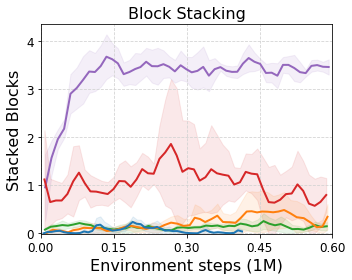

In [292]:
draw_graph(logs, title='Block Stacking', methods=methods_label.keys(), 
           xlabel='Environment steps (1M)', ylabel='Stacked Blocks', put_title=True, legend=False, legend_loc=1,
           max_step=0.6, min_y=0, max_y=5.0, smooth_steps=1, num_points=50, num_x_tick=4, smoothing_weight=0.95,
           filename="block_stacking_results")

In [271]:
# Maze
methods_label = {
    'Ours': ['_piSSMNI2-randMaze-td1-seed0-replay1e5-R2',
             '_piSSMNI2-randMaze-td1-seed1-replay1e5-R2',
             '_piSSMNI2-randMaze-td1-seed2--replay1e5-R2'],
    'Flat Prior': ['_bc-randMaze-td1-seed0',
                   '_bc-randMaze-td1-seed1',
                   '_bc-randMaze-td1-seed2'],
    'SSP w/o Prior': ['_SSM-randMaze0S40-kl1e-2-seed0--run3',
                      '_SSM-randMaze0S40-kl1e-2-seed1--run3',
                      '_SSMNoPrior-randMaze-seed2--replay1e5'],
    'SAC': ['_vRL-randMaze0S40-seed1',
            '_vRL-randMaze-seed4--replay1e5',
            '_vRL-randMaze-seed5--replay1e5'],
    'BC + finetune': ['_vRL-randMaze0S40-seed1',
                        '_vRL-randMaze-seed4--replay1e5',
                        '_vRL-randMaze-seed5--replay1e5'],

}

runs = api.runs(path='clvr/comp_imitation') #, filters={'config.env_name': 'block_stacking'})
logs = build_logs(methods_label, runs, data_key='train_episode_reward')

Ours 0 <Run clvr/comp_imitation/_piSSMNI2-randMaze-td1-seed0-replay1e5-R2 (crashed)> 895
Ours 1 <Run clvr/comp_imitation/_piSSMNI2-randMaze-td1-seed1-replay1e5-R2 (crashed)> 875
Ours 2 <Run clvr/comp_imitation/_piSSMNI2-randMaze-td1-seed2--replay1e5-R2 (crashed)> 873
Flat Prior 0 <Run clvr/comp_imitation/_bc-randMaze-td1-seed0 (crashed)> 2000
Flat Prior 1 <Run clvr/comp_imitation/_bc-randMaze-td1-seed1 (crashed)> 2015
Flat Prior 2 <Run clvr/comp_imitation/_bc-randMaze-td1-seed2 (crashed)> 1010
SSP w/o Prior 0 <Run clvr/comp_imitation/_SSM-randMaze0S40-kl1e-2-seed0--run3 (crashed)> 802
SSP w/o Prior 1 <Run clvr/comp_imitation/_SSM-randMaze0S40-kl1e-2-seed1--run3 (finished)> 1835
SSP w/o Prior 2 <Run clvr/comp_imitation/_SSMNoPrior-randMaze-seed2--replay1e5 (crashed)> 889
SAC 0 <Run clvr/comp_imitation/_vRL-randMaze0S40-seed1 (failed)> 1445
SAC 1 <Run clvr/comp_imitation/_vRL-randMaze-seed4--replay1e5 (crashed)> 2178
SAC 2 <Run clvr/comp_imitation/_vRL-randMaze-seed5--replay1e5 (failed)>

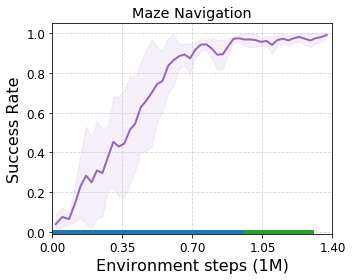

In [272]:
draw_graph(logs, title='Maze Navigation', methods=methods_label.keys(), 
           xlabel='Environment steps (1M)', ylabel='Success Rate', put_title=True, legend=False, legend_loc=2,
           max_step=1.4, min_y=0, max_y=1., smooth_steps=1, num_points=50, num_x_tick=4, smoothing_weight=0.95,
           filename='maze_results')

In [23]:
# Kitchen
methods_label = {
    'Ours': ['_piSSM-kitchen-td5-seed0--kl5e-4',
             '_piSSM-kitchen-td5-seed2--kl5e-4',
             '_piSSM-kitchen-td5-seed3--kl5e-4'],
    'Flat Prior': ['_flatPrior-kitchen-td_1-seed0-orig',
                   '_flatPrior-kitchen-td_1-seed1-orig',
                   '_flatPrior-kitchen-td_1-seed2-orig'],
    'SAC': ['_vRL-kitchen-seed0-orig',
            '_vRL-kitchen-seed1-orig',
            '_vRL-kitchen-seed2-orig'],
    'SSP w/o Prior': ['_SSM-kitchen-noPrior-kl5e-4--seed0',
                      '_SSM-kitchen-noPrior-kl5e-4--seed1',
                      '_SSM-kitchen-noPrior-kl5e-4--seed2'],
    'BC + finetune': ['_bcFinetune-kitchen-seed0-orig',
                        '_bcFinetune-kitchen-seed1-orig',
                        '_bcFinetune-kitchen-seed2-orig'],
}

runs = api.runs(path='clvr/comp_imitation') #, filters={'config.env_name': 'block_stacking'})
logs = build_logs(methods_label, runs, data_key='train_episode_reward')

Ours 0 <Run clvr/comp_imitation/_piSSM-kitchen-td5-seed0--kl5e-4 (crashed)> 9959
Ours 1 <Run clvr/comp_imitation/_piSSM-kitchen-td5-seed2--kl5e-4 (crashed)> 6579
Ours 2 <Run clvr/comp_imitation/_piSSM-kitchen-td5-seed3--kl5e-4 (crashed)> 6381
Flat Prior 0 <Run clvr/comp_imitation/_flatPrior-kitchen-td_1-seed0-orig (crashed)> 9989
Flat Prior 1 <Run clvr/comp_imitation/_flatPrior-kitchen-td_1-seed1-orig (crashed)> 10007
Flat Prior 2 <Run clvr/comp_imitation/_flatPrior-kitchen-td_1-seed2-orig (crashed)> 10056
SAC 0 <Run clvr/comp_imitation/_vRL-kitchen-seed0-orig (crashed)> 9995
SAC 1 <Run clvr/comp_imitation/_vRL-kitchen-seed1-orig (crashed)> 9954
SAC 2 <Run clvr/comp_imitation/_vRL-kitchen-seed2-orig (crashed)> 9972
SSP w/o Prior 0 <Run clvr/comp_imitation/_SSM-kitchen-noPrior-kl5e-4--seed0 (crashed)> 10003
SSP w/o Prior 1 <Run clvr/comp_imitation/_SSM-kitchen-noPrior-kl5e-4--seed1 (crashed)> 9609
SSP w/o Prior 2 <Run clvr/comp_imitation/_SSM-kitchen-noPrior-kl5e-4--seed2 (crashed)> 999

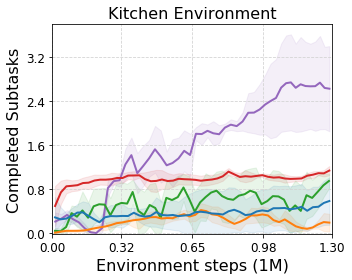

In [24]:
draw_graph(logs, title='Kitchen Environment', methods=methods_label.keys(), 
           xlabel='Environment steps (1M)', ylabel='Completed Subtasks', put_title=True, legend=False, legend_loc=2,
           max_step=1.3, min_y=0, max_y=4.0, smooth_steps=1, num_points=50, num_x_tick=4, 
           smoothing_weight=[0.95, 0.995, 0.95, 0.995, 0.995], filename='kitchen_results')

In [307]:
# Skill Length Ablation
methods_label = {
    'H = 30': ['_piSSMNI2-stack-td5-seed0--N30',
               '_piSSMNI2-stack-td5-seed1--N30',
               '_piSSMNI2-stack-td5-seed2--N30'],
    'H = 10': ['_piSSMNI2-stack-td5-seed0--run3',
               '_piSSMNI2-stack-td5-seed1--run3',
               '_piSSMNI2-blocks-td5-seed2'],
    'H = 3': ['_piSSMNI2-stack-td5-seed0--N3--run2',
              '_piSSMNI2-stack-td5-seed2--N3--run2',
              '_piSSMNI2-stack-td5-seed3--N3--run2'],
}

runs = api.runs(path='clvr/comp_imitation') #, filters={'config.env_name': 'block_stacking'})
logs = build_logs(methods_label, runs, data_key='train_block_4_stack')

H = 30 0 <Run clvr/comp_imitation/_piSSMNI2-stack-td5-seed0--N30 (crashed)> 2056
H = 30 1 <Run clvr/comp_imitation/_piSSMNI2-stack-td5-seed1--N30 (crashed)> 1940
H = 30 2 <Run clvr/comp_imitation/_piSSMNI2-stack-td5-seed2--N30 (crashed)> 1932
H = 10 0 <Run clvr/comp_imitation/_piSSMNI2-stack-td5-seed0--run3 (crashed)> 1670
H = 10 1 <Run clvr/comp_imitation/_piSSMNI2-stack-td5-seed1--run3 (running)> 1662
H = 10 2 <Run clvr/comp_imitation/_piSSMNI2-blocks-td5-seed2 (failed)> 687
H = 3 0 <Run clvr/comp_imitation/_piSSMNI2-stack-td5-seed0--N3--run2 (crashed)> 1839
H = 3 1 <Run clvr/comp_imitation/_piSSMNI2-stack-td5-seed2--N3--run2 (crashed)> 1764
H = 3 2 <Run clvr/comp_imitation/_piSSMNI2-stack-td5-seed3--N3--run2 (crashed)> 1817


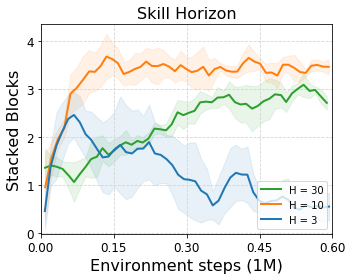

In [308]:
draw_graph(logs, title='Skill Horizon', methods=methods_label.keys(), 
           xlabel='Environment steps (1M)', ylabel='Stacked Blocks', put_title=True, legend=True, legend_loc=4,
           max_step=0.6, min_y=0, max_y=5.0, smooth_steps=1, num_points=50, num_x_tick=4, smoothing_weight=0.95,
           filename="skill_horizon_ablation")

In [294]:
# Skill Embedding Dimension Ablation
methods_label = {
    '|Z| = 30': ['_piSSMNI2-stack-nz30-seed0',
                 '_piSSMNI2-stack-nz30-seed1',
                 '_piSSMNI2-stack-nz30-seed2'],
    '|Z| = 10': ['_piSSMNI2-stack-td5-seed0--run3',
                 '_piSSMNI2-stack-td5-seed1--run3',
                 '_piSSMNI2-blocks-td5-seed2'],
    '|Z| = 2': ['_piSSMNI2-blocks-nz2-td5--seed0',
                '_piSSMNI2-blocks-nz2-td5--seed1',
                '_piSSMNI2-blocks-nz2-td5--seed2'],
}

runs = api.runs(path='clvr/comp_imitation') #, filters={'config.env_name': 'block_stacking'})
logs = build_logs(methods_label, runs, data_key='train_block_4_stack')

|Z| = 30 0 <Run clvr/comp_imitation/_piSSMNI2-stack-nz30-seed0 (crashed)> 658
|Z| = 30 1 <Run clvr/comp_imitation/_piSSMNI2-stack-nz30-seed1 (failed)> 666
|Z| = 30 2 <Run clvr/comp_imitation/_piSSMNI2-stack-nz30-seed2 (failed)> 657
|Z| = 10 0 <Run clvr/comp_imitation/_piSSMNI2-stack-td5-seed0--run3 (crashed)> 1670
|Z| = 10 1 <Run clvr/comp_imitation/_piSSMNI2-stack-td5-seed1--run3 (running)> 1662
|Z| = 10 2 <Run clvr/comp_imitation/_piSSMNI2-blocks-td5-seed2 (failed)> 687
|Z| = 2 0 <Run clvr/comp_imitation/_piSSMNI2-blocks-nz2-td5--seed0 (running)> 752
|Z| = 2 1 <Run clvr/comp_imitation/_piSSMNI2-blocks-nz2-td5--seed1 (running)> 767
|Z| = 2 2 <Run clvr/comp_imitation/_piSSMNI2-blocks-nz2-td5--seed2 (running)> 765


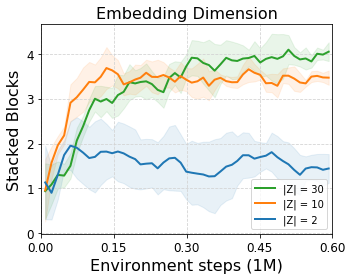

In [295]:
draw_graph(logs, title='Embedding Dimension', methods=methods_label.keys(), 
           xlabel='Environment steps (1M)', ylabel='Stacked Blocks', put_title=True, legend=True, legend_loc=4,
           max_step=0.6, min_y=0, max_y=5.0, smooth_steps=1, num_points=50, num_x_tick=4, smoothing_weight=0.95,
           filename="embedding_dim_ablation")

In [9]:
# w/ vs w/o state conditioned decode (on maze)
methods_label = {
    'Ours': ['_piSSMNI2-randMaze-td1-seed0-replay1e5-R2',
             '_piSSMNI2-randMaze-td1-seed1-replay1e5-R2',
             '_piSSMNI2-randMaze-td1-seed2--replay1e5-R2'],
    'Ours w/ state cond.': ['_piSSM-maze-seed0-td1-kl1e-2',
                   '_piSSM-maze-seed1-td1-kl1e-2',
                   '_piSSM-maze-seed2-td1-kl1e-2'],
    'SSP w/o Prior': ['_SSM-randMaze0S40-kl1e-2-seed0--run3',
                      '_SSM-randMaze0S40-kl1e-2-seed1--run3',
                      '_SSMNoPrior-randMaze-seed2--replay1e5'],
    'SSP w/o Prior w/ state cond.': ['_SSM_condDecode_maze_run2_seed0',
            '_SSM_condDecode_maze_run2_seed1',
            '_SSM_condDecode_maze_run2_seed2'],
}

runs = api.runs(path='clvr/comp_imitation') #, filters={'config.env_name': 'block_stacking'})
logs = build_logs(methods_label, runs, data_key='train_episode_reward')

Ours 0 <Run clvr/comp_imitation/_piSSMNI2-randMaze-td1-seed0-replay1e5-R2 (crashed)> 895
Ours 1 <Run clvr/comp_imitation/_piSSMNI2-randMaze-td1-seed1-replay1e5-R2 (crashed)> 875
Ours 2 <Run clvr/comp_imitation/_piSSMNI2-randMaze-td1-seed2--replay1e5-R2 (crashed)> 873
Ours w/ state cond. 0 <Run clvr/comp_imitation/_piSSM-maze-seed0-td1-kl1e-2 (crashed)> 504
Ours w/ state cond. 1 <Run clvr/comp_imitation/_piSSM-maze-seed1-td1-kl1e-2 (crashed)> 456
Ours w/ state cond. 2 <Run clvr/comp_imitation/_piSSM-maze-seed2-td1-kl1e-2 (crashed)> 458
SSP w/o Prior 0 <Run clvr/comp_imitation/_SSM-randMaze0S40-kl1e-2-seed0--run3 (crashed)> 802
SSP w/o Prior 1 <Run clvr/comp_imitation/_SSM-randMaze0S40-kl1e-2-seed1--run3 (finished)> 1835
SSP w/o Prior 2 <Run clvr/comp_imitation/_SSMNoPrior-randMaze-seed2--replay1e5 (crashed)> 889
SSP w/o Prior w/ state cond. 0 <Run clvr/comp_imitation/_SSM_condDecode_maze_run2_seed0 (finished)> 1819
SSP w/o Prior w/ state cond. 1 <Run clvr/comp_imitation/_SSM_condDecode_

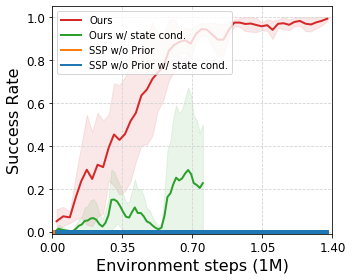

In [14]:
draw_graph(logs, title='Maze Navigation', methods=methods_label.keys(), 
           xlabel='Environment steps (1M)', ylabel='Success Rate', put_title=False, legend=True, legend_loc=2,
           max_step=1.4, min_y=0, max_y=1., smooth_steps=1, num_points=50, num_x_tick=4, smoothing_weight=0.95,
           filename='state_cond_maze_results')

In [5]:
# Prior Regularization Ablation
methods_label = {
    'Ours': ['_piSSMNI2-stack-td5-seed0--run3',
             '_piSSMNI2-stack-td5-seed1--run3',
             '_piSSMNI2-blocks-td5-seed2'],
    'SSP PriorInit + SAC': ['_piSSM-blocks-vanillaSAC-seed0',
                            '_piSSM-blocks-vanillaSAC-seed1',
                            '_piSSM-blocks-vanillaSAC-seed2'],
}

runs = api.runs(path='clvr/comp_imitation', filters={'config.env_name': 'block_stacking'})
logs = build_logs(methods_label, runs, data_key='train_block_4_stack')

Ours 0 <Run clvr/comp_imitation/_piSSMNI2-stack-td5-seed0--run3 (crashed)> 1670
Ours 1 <Run clvr/comp_imitation/_piSSMNI2-stack-td5-seed1--run3 (running)> 1662
Ours 2 <Run clvr/comp_imitation/_piSSMNI2-blocks-td5-seed2 (failed)> 687
SSP PriorInit + SAC 0 <Run clvr/comp_imitation/_piSSM-blocks-vanillaSAC-seed0 (running)> 3081
SSP PriorInit + SAC 1 <Run clvr/comp_imitation/_piSSM-blocks-vanillaSAC-seed1 (running)> 3125
SSP PriorInit + SAC 2 <Run clvr/comp_imitation/_piSSM-blocks-vanillaSAC-seed2 (running)> 3147


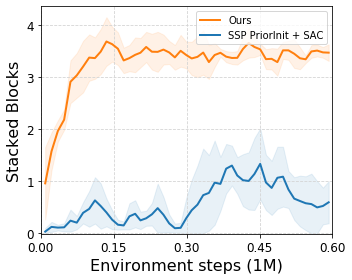

In [7]:
draw_graph(logs, title='Block Stacking', methods=methods_label.keys(), 
           xlabel='Environment steps (1M)', ylabel='Stacked Blocks', put_title=False, legend=True, legend_loc=1,
           max_step=0.6, min_y=0, max_y=5.0, smooth_steps=1, num_points=50, num_x_tick=4, smoothing_weight=0.95,
           filename="PI_uniform_blocks_result")